## Neural Collaborative Filtering 
* 저자 code : https://github.com/hexiangnan/neural_collaborative_filtering
* Keras docs reference : https://keras.io/examples/structured_data/collaborative_filtering_movielens/
* paper 에서는 implicit feedback 을 학습하는 것을 실험했으나, 아래 실습에서는 직접 rating prediction 을 진행

In [1]:
import pandas as pd
import numpy as np
import keras
import tensorflow as tf
from keras import layers
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
# Check for tensorflow GPU acess
print("TensorFlow has access to the following devices:", tf.config.list_physical_devices())

# See TensorFlow version
print("TensorFlow version:", tf.__version__)

TensorFlow has access to the following devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version: 2.9.0


In [3]:
path = './kmrd/kmr_dataset/datafile/kmrd-small/'

In [4]:
df = pd.read_csv(path + 'rates.csv')
df.columns = ['userId','movieId','rating','time']
df.head()

,userId,movieId,rating,time
0,0,10003,7,1494128040
1,0,10004,7,1467529800
2,0,10018,9,1513344120
3,0,10021,9,1424497980
4,0,10022,7,1427627340


In [5]:
df['rating'].describe()

count    140710.000000
mean          8.953258
std           2.106047
min           1.000000
25%           9.000000
50%          10.000000
75%          10.000000
max          10.000000
Name: rating, dtype: float64

In [6]:
# encoding user & moive ids
user_ids = df["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
movie_ids = df["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
df["user"] = df["userId"].map(user2user_encoded)
df["movie"] = df["movieId"].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)

df["rating"] = df["rating"].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later
min_rating = min(df["rating"])
max_rating = max(df["rating"])

print(
    "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_movies, min_rating, max_rating
    )
)

Number of users: 52028, Number of Movies: 600, Min rating: 1.0, Max rating: 10.0


In [7]:
df.head()

,userId,movieId,rating,time,user,movie
0,0,10003,7.0,1494128040,0,0
1,0,10004,7.0,1467529800,0,1
2,0,10018,9.0,1513344120,0,2
3,0,10021,9.0,1424497980,0,3
4,0,10022,7.0,1427627340,0,4


In [8]:
train_df, val_df = train_test_split(df[['user','movie','rating']], test_size=.1)
print(train_df.shape,val_df.shape)

(126639, 3) (14071, 3)


In [9]:
X_train = train_df[["user", "movie"]]
y_train = train_df['rating'] / 10.0
X_val = val_df[["user", "movie"]]
y_val = val_df['rating'] / 10.0

In [10]:
EMBEDDING_SIZE = 50

class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super().__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)
        self.dense = layers.Dense(64, activation="relu")
        self.output_layer = layers.Dense(1, activation="sigmoid")

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # fc_layer = self.dense(x)

        # The sigmoid activation forces the rating to between 0 and 1
        return self.output_layer(x)

model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.001)
    )

Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2024-11-07 16:02:37.569143: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-07 16:02:37.569269: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [11]:
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=64,
    epochs=5,
    verbose=1,
    validation_data=(X_val, y_val),
)

Epoch 1/5


2024-11-07 16:02:37.735953: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-11-07 16:02:38.196797: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1979/1979 [==============================] - ETA: 0s - loss: 0.3770

2024-11-07 16:03:18.889991: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1979/1979 [==============================] - 44s 22ms/step - loss: 0.3770 - val_loss: 0.3247
Epoch 2/5
1979/1979 [==============================] - 42s 21ms/step - loss: 0.3217 - val_loss: 0.3239
Epoch 3/5
1979/1979 [==============================] - 42s 21ms/step - loss: 0.3136 - val_loss: 0.3186
Epoch 4/5
1979/1979 [==============================] - 41s 21ms/step - loss: 0.3085 - val_loss: 0.3136
Epoch 5/5
1979/1979 [==============================] - 41s 21ms/step - loss: 0.3045 - val_loss: 0.3106


In [12]:
model.summary()

Model: "recommender_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  2601400   
                                                                 
 embedding_1 (Embedding)     multiple                  52028     
                                                                 
 embedding_2 (Embedding)     multiple                  30000     
                                                                 
 embedding_3 (Embedding)     multiple                  600       
                                                                 
 dense (Dense)               multiple                  0 (unused)
                                                                 
 dense_1 (Dense)             multiple                  2         
                                                                 
Total params: 2,684,030
Trainable params: 2,684,030

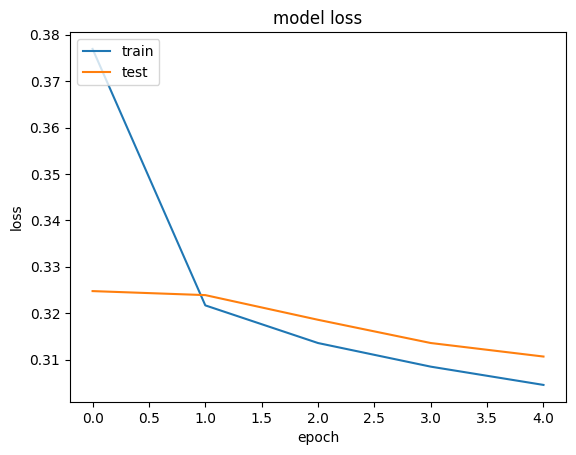

In [13]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [14]:
movie_df = pd.read_csv(path+"movie_info.csv")
movie_df = movie_df.rename(columns={'movie':'movieId'})
movie_df.head()

,movieId,title,title_eng,year,grade,genres,people
0,10001,시네마 천국,"Cinema Paradiso , 1988",2013.0,전체 관람가,드라마/멜로/로맨스,[ 4374 178 3241 47952 47953 19538 18991 479...
1,10002,빽 투 더 퓨쳐,"Back To The Future , 1985",2015.0,12세 관람가,SF/코미디,[1076 4603 917 8637 5104 9986 7470 9987]
2,10003,빽 투 더 퓨쳐 2,"Back To The Future Part 2 , 1989",2015.0,12세 관람가,SF/코미디,[1076 4603 917 5104 391 5106 5105 5107 580 ...
3,10004,빽 투 더 퓨쳐 3,"Back To The Future Part III , 1990",1990.0,전체 관람가,서부/SF/판타지/코미디,[ 1076 4603 1031 5104 10001 5984 10002 100...
4,10005,스타워즈 에피소드 4 - 새로운 희망,"Star Wars , 1977",1997.0,PG,판타지/모험/SF/액션,[1007 535 215 1236 35]


In [15]:
tmp_cnt = df.groupby('userId')['movieId'].count().reset_index()
tmp_cnt[tmp_cnt.movieId>20]

,userId,movieId
0,0,85
3,3,92
4,4,71
9,9,22
14,14,24
...,...,...
20906,20906,27
23332,23332,22
25052,25052,21
25094,25094,35


In [28]:
# sample user
user_id = tmp_cnt[tmp_cnt.movieId>20]['userId'].sample(1).iloc[0]
user_id

1446

In [32]:
movies_watched_by_user = df[df.userId == user_id]
movies_not_watched = movie_df[
    ~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)
]["movieId"]
movies_not_watched = list(
    set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
)
movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
user_encoder = user2user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)
user_movie_array.shape

(579, 2)

In [33]:
ratings = model.predict(user_movie_array).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]

19/19 [==============================] - 1s 45ms/step


In [34]:
print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Movies with high ratings from user")
print("----" * 8)
top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(10)
    .movieId.values
)
movie_df_rows = movie_df[movie_df["movieId"].isin(top_movies_user)]
for row in movie_df_rows.itertuples():
    print(row.title, ":", row.genres, row.year)

print("----" * 8)
print("Top 10 movie recommendations")
print("----" * 8)
recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres, row.year)

Showing recommendations for user: 1446
Movies with high ratings from user
--------------------------------
시네마 천국 : 드라마/멜로/로맨스 2013.0
빽 투 더 퓨쳐 : SF/코미디 2015.0
레인 맨 : 드라마 1989.0
모던 타임즈 : 코미디 2015.0
해리가 샐리를 만났을 때 : 멜로/로맨스/코미디 2016.0
배트맨 : 액션/스릴러/범죄 1990.0
졸업 : 드라마/코미디 2020.0
미져리 : 드라마/스릴러/공포 1991.0
인어 공주 : 멜로/로맨스/애니메이션/코미디/판타지/뮤지컬/모험/가족 1997.0
영구와 땡칠이 : 가족/모험/코미디 1989.0
--------------------------------
Top 10 movie recommendations
--------------------------------
빽 투 더 퓨쳐 2 : SF/코미디 2015.0
다이 하드 : 액션/스릴러/범죄 1988.0
나 홀로 집에 : 코미디/가족/모험/범죄 1991.0
이티 : 판타지/SF/모험/가족 2011.0
맹룡과강 : 액션/코미디/범죄 2013.0
로미오와 줄리엣 : 멜로/로맨스/드라마 1978.0
로보캅 : SF/액션/범죄 1987.0
수잔 브링크의 아리랑 : 드라마 1991.0
베어 : 드라마 1992.0
분노의 역류 : 드라마 1991.0
